# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [159]:
import os

In [160]:
import gymnasium as gym
import numpy as np, pandas as pd

# env = gym.make("Taxi-v3", render_mode="human")
env = gym.make("Taxi-v3")
env.reset()
# env.render()

(487, {'prob': 1.0, 'action_mask': array([0, 1, 0, 1, 0, 0], dtype=int8)})

In [161]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


# Initialize policy (0.5pts)

In [162]:
import numpy as np
policy = np.ones((n_states, n_actions)) / n_actions
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
print("Ok!")

Ok!


# Play the game (0.5pts)

Just like before, but we also record all states and actions we took.

In [163]:
def generate_session(policy,t_max=500):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s, _ = env.reset()
    
    for t in range(t_max):
        a = np.random.choice(range(n_actions), p = policy[s])
        
        new_s, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        #Record state, action and add up reward to states,actions and total_reward accordingly.
                #add state
        states.append(s)
                #add action
        actions.append(a)
        #add reward
        total_reward += r

        
        s = new_s
        if done:
            break
    return states,actions,total_reward
        

In [164]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert isinstance(r, (float, np.float64))

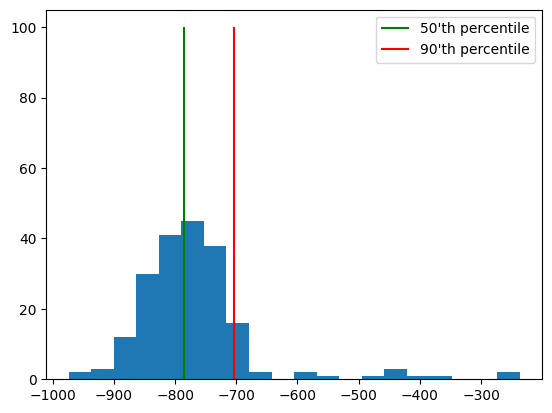

In [165]:
#let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()

### Crossentropy method steps (1pts)

In [166]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    # reward_threshold = #recalc threshold. hint : np.percentile
    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_actions = []
    elite_states = []
    for states, actions, reward in zip(states_batch, actions_batch, rewards_batch):
        if reward >= reward_threshold:
            elite_states.append(states)
            elite_actions.append(actions)
    if len(np.array(states_batch[0]).shape) == 1:
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)

    elite_actions = np.hstack(elite_actions)

    return list(elite_states), list(elite_actions)
    

In [167]:
import numpy as np
states_batch = ([
    np.array([1,2,3]),   #game1
    np.array([4,2,0,2]), #game2
    np.array([3,1])      #game3
])

actions_batch = ([
    np.array([0,2,4]),   #game1
    np.array([3,2,0,1]), #game2
    np.array([3,3])      #game3
])
rewards_batch = np.array([
    3,         #game1
    4,         #game2
    5,         #game3
])

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [168]:
def update_policy(elite_states,elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    new_policy = np.zeros([n_states,n_actions])
    for s, a in zip(elite_states, elite_actions):
        new_policy[s, a] += 1
    for s in range(n_states):
        total = np.sum(new_policy[s])
        if total > 0:
            new_policy[s] /= total
        else:
            new_policy[s] = 1.0 / n_actions
    #<Your code here: update probabilities for actions given elite states & actions>
    #Don't forget to set 1/n_actions for all actions in unvisited states.
    
    return new_policy

In [169]:

elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
print(new_policy[:4,:5])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Ok!


# Training loop (1pts)
Generate sessions, select N best and fit to those.

In [170]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def show_progress(rewards_batch,log, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [171]:
#reset policy just in case


In [172]:
# n_sessions = 250  #sample this many sessions
# percentile = 70  #take this percent of session with highest rewards
# learning_rate = 0.5  #add this thing to all counts for stability
#
# log = []
#
# for i in range(100):
#    # генерируем сессии
#     sessions = [generate_session(policy) for _ in range(n_sessions)]
#
#     states_batch, actions_batch, rewards_batch = zip(*sessions)
#
#     # выбираем элитные состояния/действия
#     elite_states, elite_actions = select_elites(
#         states_batch, actions_batch, rewards_batch, percentile=100 - percentile
#     )
#
#     # обновляем политику
#     new_policy = update_policy(elite_states, elite_actions)
#     policy = learning_rate * new_policy + (1 - learning_rate) * policy
#
#     # отображаем прогресс
#     show_progress(rewards_batch, log)

# Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples. Show all precentiles on one graph and all n_samples on another
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [173]:
import numpy as np, pandas as pd
import gymnasium as gym

env = gym.make("Taxi-v3")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n
policy = 1/6. * np.ones([n_states, n_actions])
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert isinstance(r, (float, np.float64))
policy = np.ones([n_states,n_actions])/n_actions 
stepCounter = 60

In [174]:
# n_sessions = 250  #sample this many sessions
# percentiles = [30, 50, 70, 90]  #take this percent of session with highest rewards
# learning_rate = 0.5  #add this thing to all counts for stability
# mean_by_percentile = {}
#
#
# log = []
# mean = []
# for percentile in percentiles:
#     curMean = []
#     policy = np.ones([n_states,n_actions])/n_actions
#     for i in range(stepCounter):
#
#         %time sessions = [generate_session(policy) for _ in range(n_sessions)]
#
#         states_batch,actions_batch,rewards_batch = zip(*sessions)
#
#         elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile=100 -percentile)
#         new_policy = update_policy(elite_states, elite_actions)
#         policy = learning_rate * new_policy + (1 - learning_rate) * policy
#
#         curMean.append(np.mean(rewards_batch))
#         #set new policy
#         #update policy
#         #add mean value
#     mean_by_percentile[percentile] = curMean  # сохраняем результаты для этого percentile
#     #display results on chart
# plt.figure(figsize=(8,5))
# for percentile, mean_rewards in mean_by_percentile.items():
#     plt.plot(mean_rewards, label=f'percentile={percentile}')
# plt.xlabel('Iteration')
# plt.ylabel('Mean reward')
# plt.title('Effect of percentile on learning')
# plt.legend()
# plt.grid()
# plt.show()

# How do different percentiles affect training efficiency?

Низкие процентили (например, 30 - 10%) - быстрый рост, но большой риск застрять в локальном
максимуме из-за того, что мало новых данных.

Средние процентили (около 50%) - лучший компромисс, стабильное и эффективное обучение.

Высокие процентили (70%) - медленный рост, обновления размываются низкоэффективными сессиями.

In [175]:
# n_sessions_ar = [100, 200, 300, 400]  #sample this many sessions
# perc = 50  #take this percent of session with highest rewards
# learning_rate = 0.5  #add this thing to all counts for stability
#
# log = []
# mean = []
# for n_sessions in n_sessions_ar:
#     curMean = []
#     policy = np.ones([n_states,n_actions])/n_actions
#     for i in range(stepCounter):
#
#         %time sessions = [generate_session(policy) for _ in range(n_sessions)]
#
#         states_batch,actions_batch,rewards_batch = zip(*sessions)
#
#         elite_states, elite_actions = select_elites(
#             states_batch,
#             actions_batch,rewards_batch,
#             percentile=100 - perc)
#
#         #set new policy
#         #update policy
#         #add mean value
#         new_policy = update_policy(elite_states, elite_actions)
#         policy = learning_rate * new_policy + (1 - learning_rate) * policy
#         curMean.append(np.mean(rewards_batch))
#         clear_output(True)
#     mean.append(curMean)
#     #display results on chart
#     plt.figure(figsize=(8,5))
# for idx, n_sessions in enumerate(n_sessions_ar):
#     plt.plot(mean[idx], label=f'n_sessions={n_sessions}')
# plt.xlabel('Iteration')
# plt.ylabel('Mean reward')
# plt.title('Effect of n_sessions on learning')
# plt.legend()
# plt.grid()
# plt.show()

# Stabilize positive rewards by averaging policy across 10 games (2 pts)

In [176]:
# n_sessions = 500  #sample this many sessions
# percentile = 80  #take this percent of session with highest rewards
# learning_rate = 0.31 #add this thing to all counts for stability
# #200, 70, 0.3 -- 3.45
# #200, 65, 0.3 -- 2.78
# #200, 75, 0.3 -- 3.445
# #200, 70, 0.25 -- 3.515
# #250, 70, 0.23 -- 4.624
# #300, 70, 0.23 -- 4.403
# #500, 80, 0.3 -- 6.78
# #550, 83, 0.3 -- 6.474545454545455
# #500, 82, 0.28 -- 6.778
# #500, 82, 0.3 -- 6.254
# #500, 78, 0.3 -- 5.78
# #480, 80, 0.3 -- 5.902083333333334
# log = []
# mx = -10000
# policies = []
# max_log = []
# log_file = "max_rewards.log"
# for i in range(2000):
#    # генерируем сессии
#     sessions = [generate_session(policy) for _ in range(n_sessions)]
#
#     states_batch, actions_batch, rewards_batch = zip(*sessions)
#
#     # выбираем элитные состояния/действия
#     elite_states, elite_actions = select_elites(
#         states_batch, actions_batch, rewards_batch, percentile=100 - percentile
#     )
#
#     # обновляем политику
#     new_policy = update_policy(elite_states, elite_actions)
#     policies.append(new_policy)
#     if len(policies) > 20:
#         policies.pop(0)
#
#     avg_policy = np.mean(policies, axis=0)
#
#     policy = learning_rate * avg_policy + (1 - learning_rate) * policy
#
#     # отображаем прогресс
#     show_progress(rewards_batch, log)
#     if (np.mean(rewards_batch) > mx and np.mean(rewards_batch) > -10):
#         mx = np.mean(rewards_batch)
#         max_log.append(mx)
#         with open(log_file, "a") as f:
#             f.write(f"iteration {i}: new max = {mx:.3f}\n")
#         print(f"Итерация {i}: новый максимум = {mx:.3f}")
#     if(np.mean(rewards_batch) > 7):
#         print("win!")
#         break
# print("Все максимумы:", max_log)

# Digging deeper: approximate crossentropy with neural nets (2 pts)

In this section we will train a neural network policy for continuous state space game

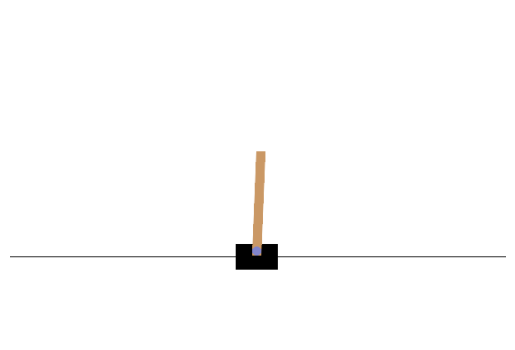

In [188]:
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, _ = env.reset()

frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.show()


In this case use NN as a black box. All your should know that it is more complex than a tabular method. 

In [189]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
X_init = np.tile(obs, (n_actions, 1))
y_init = np.arange(n_actions)
agent.partial_fit(X_init, y_init, classes=np.arange(n_actions))


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20), max_iter=1,
              warm_start=True)

In [190]:
def generate_session(t_max=500):
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):
        probs = agent.predict_proba([s])[0]  # shape = (n_actions,)

        a = np.random.choice(np.arange(n_actions), p=probs)

        new_s, r, done, truncated, info = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done or truncated:
            break

    return states, actions, total_reward


In [191]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    reward_threshold = np.percentile(rewards_batch,percentile)

    elite_states = []
    elite_actions = []

    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    # превращаем списки в numpy-массивы
    elite_states = np.array(elite_states)
    elite_actions = np.array(elite_actions)

    return elite_states, elite_actions


To train this classification model use fit(states, actions). In this case we are training classificator to predict the correct class (action) in a given state

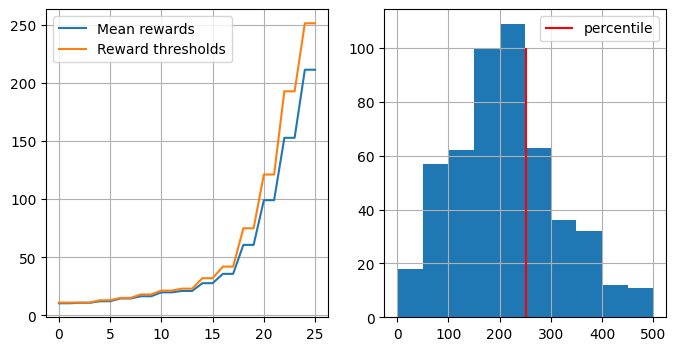

Iter 12: mean_reward=211.60, threshold=251.6, elite_size=49774
🎉 You Win! Training complete.


In [196]:
import numpy as np
from sklearn.neural_network import MLPClassifier
hidden_layer_sizes = (64,64)
n_sessions = 500
percentile = 70
log = []

for i in range(100):
    sessions = [generate_session() for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)

    # объединяем все сессии в один массив для обучения
    X_train = np.vstack(states_batch)       # shape = (total_steps, n_features)
    y_train = np.hstack(actions_batch)
    elite_states, elite_actions = select_elites(
        states_batch, actions_batch, rewards_batch, percentile= percentile
    )

    agent.partial_fit(elite_states, elite_actions, classes=np.arange(n_actions))

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append((mean_reward, threshold))  # сохраняем и среднее,    log.append(mean_reward)

    show_progress(rewards_batch, log, reward_range=[0, np.max(rewards_batch)])

    print(f"Iter {i}: mean_reward={mean_reward:.2f}, "
          f"threshold={np.percentile(rewards_batch, percentile):.1f}, "
          f"elite_size={len(elite_states)}")

    if mean_reward > 190:
        print("🎉 You Win! Training complete.")
        break


# Report (1 pts)

In [193]:
# Describe what you did here.  Preferably with plot/report to support it